In [1]:
import sys
sys.path.append('../src/')
import warnings
import os
import re
import gc
from tqdm.notebook import tqdm
import string
import nltk
import logging
import scipy as sc
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as sts

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,\
f1_score, roc_auc_score, classification_report  # plot_confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

# import statsmodels.formula.api as smf
# import statsmodels.stats.api as sms
from plotly.offline import plot, iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from pandas.plotting import register_matplotlib_converters
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm_notebook
from functools import partial

from stop_words_cz import STOP_WORDS
from utils import remove_stop_words, text_process, clean_text
from dl import ngram_vectorize

register_matplotlib_converters()

pallet = 'ggplot'
plt.style.use(pallet)
cmap = ListedColormap(sns.color_palette())
# sns.set()

params = { 
    'figure.figsize': np.array([10, 6])
}
plt.rcParams.update(params)

warnings.filterwarnings("ignore")

%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('in module %(name)s, in func %(funcName)s, '
                              '%(levelname)-8s: [%(filename)s:%(lineno)d] %(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
if not len(logger.handlers):
    logger.addHandler(stream_handler)
    logger.propagate = False

# Brief plan:

1) __[EDA and insights](#eda)<br><br>__

2) __[Working with features](#feat)<br><br>__

3) __[Literature review and problem state-of-art](#lit)<br><br>__

4) __[Building baseline](#base)<br><br>__

5) __[LSTM with Keras](#lstm)<br><br>__

6) __[LSTM with fasttext embeddings](#emb)<br><br>__

7) __[Dealing with imbalanced data](#imbalanced)<br><br>__

8) __[STM on mutated data](#lstm_mut)<br><br>__

9) __[Conclusions and further work](#cocnlusion)<br><br>__

# ____1. EDA____
<a id="eda"></a>

In [3]:
data_folder = os.path.join('..', 'data')
data = pd.read_csv('../data/sportoclanky.csv')
print(data.shape)
data.head(2)

(111218, 3)


,category,rss_title,rss_perex
0,biatlon,"Krčmář dojel v hromadném závodě devátý, díky s...",Závod s hromadným startem v německém Oberhofu ...
1,biatlon,Česká vlajka byla v Pokljuce vidět i ve štafet...,Galerie


In [4]:
data.iloc[np.random.choice(data.index, 10, replace=False)]

,category,rss_title,rss_perex
40397,hokej,"Náš tým má velkou sílu a potenciál, říká Kašpa...",Lukáš Kašpar se raduje se spoluhráči z rozhodu...
101983,tenis,"Kvitová v Birminghamu končí v 2. kole, vypadla...",Česká tenistka Petra Kvitová skončila na turna...
83690,tenis,Anett Kontaveitová,Hertogenbosch (Nizozemsko) - Estonská tenistka...
85324,fotbal,Parádní premiéra! Zelenáč Jankto potvrdil form...,"Ač zelenáč, výkonem při prvním startu v elitní..."
55115,hokej,Plekanec prvním gólem sezony zařídil výhru Mon...,Tomáš Plekanec se prvním gólem v letošní sezon...
12938,olympijske_hry,"USA a Rio? Anthonyho útok na hattrick, Duranto...",Američtí basketbalisté nemohou vzít do Ria de ...
37863,fotbal,"Schick do Anglie? Bude se jednat, píší v Itáli...",Velký přestup na obzoru? Italská média informu...
93239,tenis,Berdych oplatil porážku Haasemu a je v osmifinále,ATP MADRID - Tomáš Berdych zvládl na oblíbeném...
29008,hokej,Jandač o nominaci na Karjalu: Oproti SP se to ...,Premiéru v podobě Světového poháru má kouč Jos...
87658,hokej,Po hokejistech zkrachovalého skalického klubu ...,Bývalí hokejisté HK 36 Skalica obdrželi v uply...


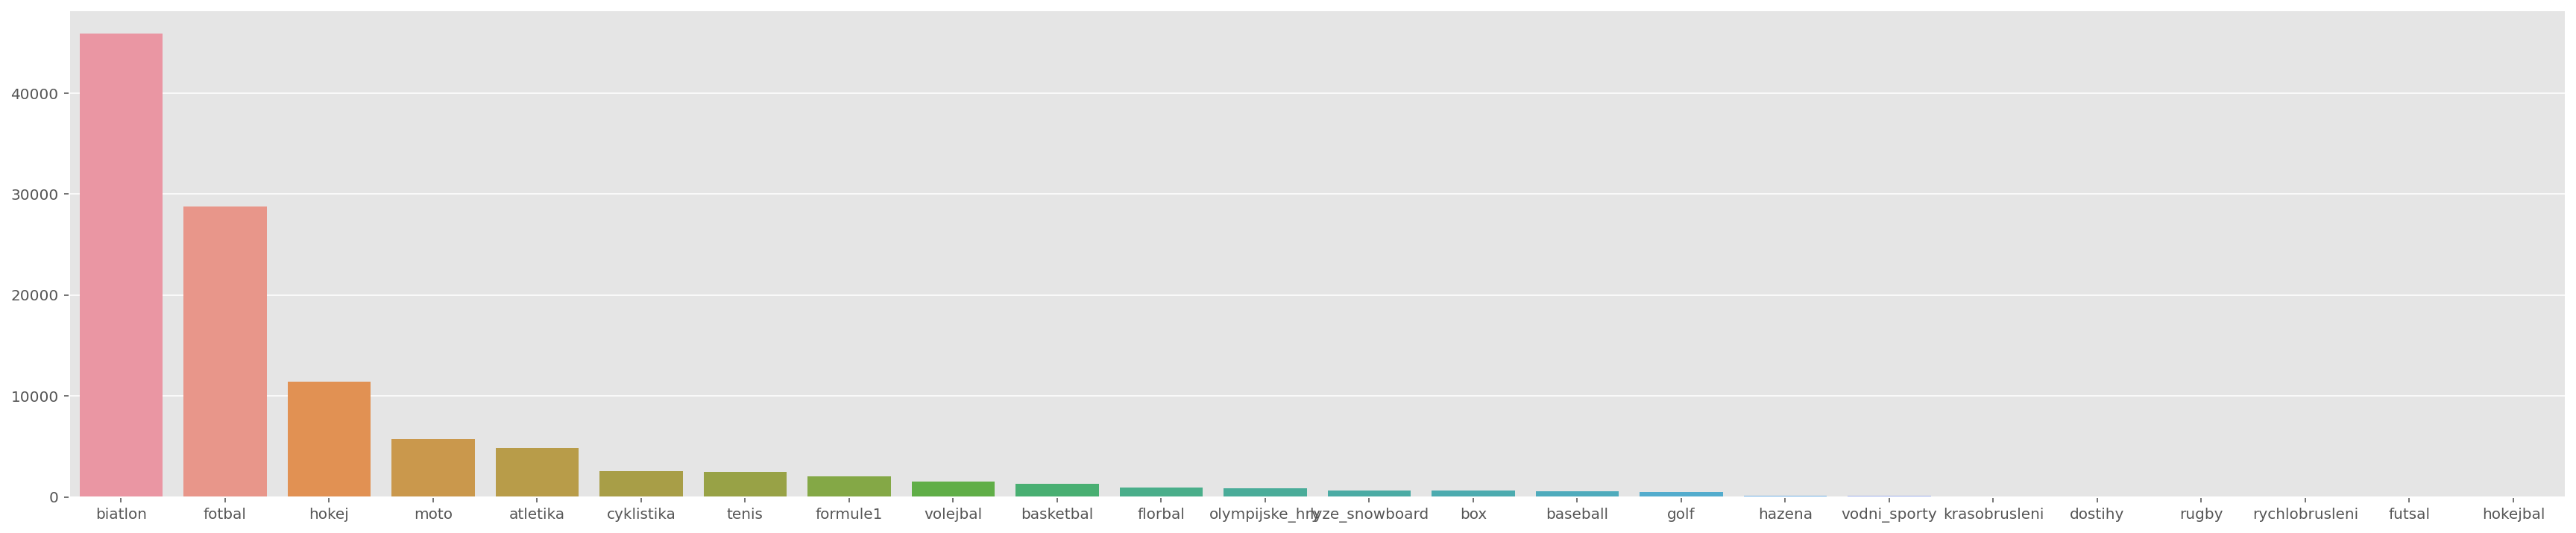

In [5]:
plt.figure(figsize=(30, 6))
sns.barplot(x=data.category.unique(), y=data.category.value_counts().values);

# The distro above is quite wierd as I expected that footbal take first place or there's an error in labelling.
## But as I'm not expert I would refer this to an expert in the domain.

In [6]:
cats = pd.DataFrame(data['category'].value_counts())
cats

,category
fotbal,45891
hokej,28775
tenis,11437
formule1,5733
moto,4813
atletika,2552
basketbal,2492
cyklistika,2048
biatlon,1526
olympijske_hry,1322


In [7]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_sample_length_distribution(sample_texts, title=None, c=None):
    plt.figure(figsize=(10, 6))
    if c is not None:
        plt.hist([len(s) for s in sample_texts], 50, color=c)
    else:
        plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.show()

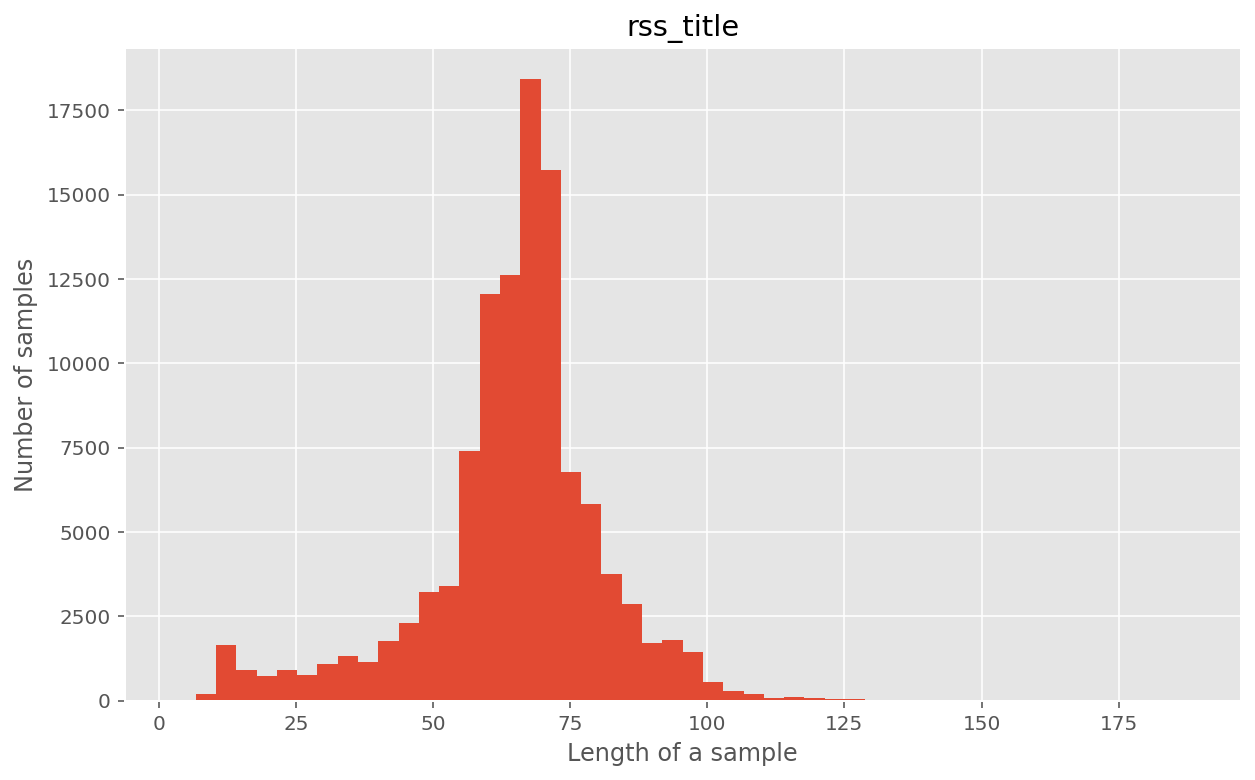

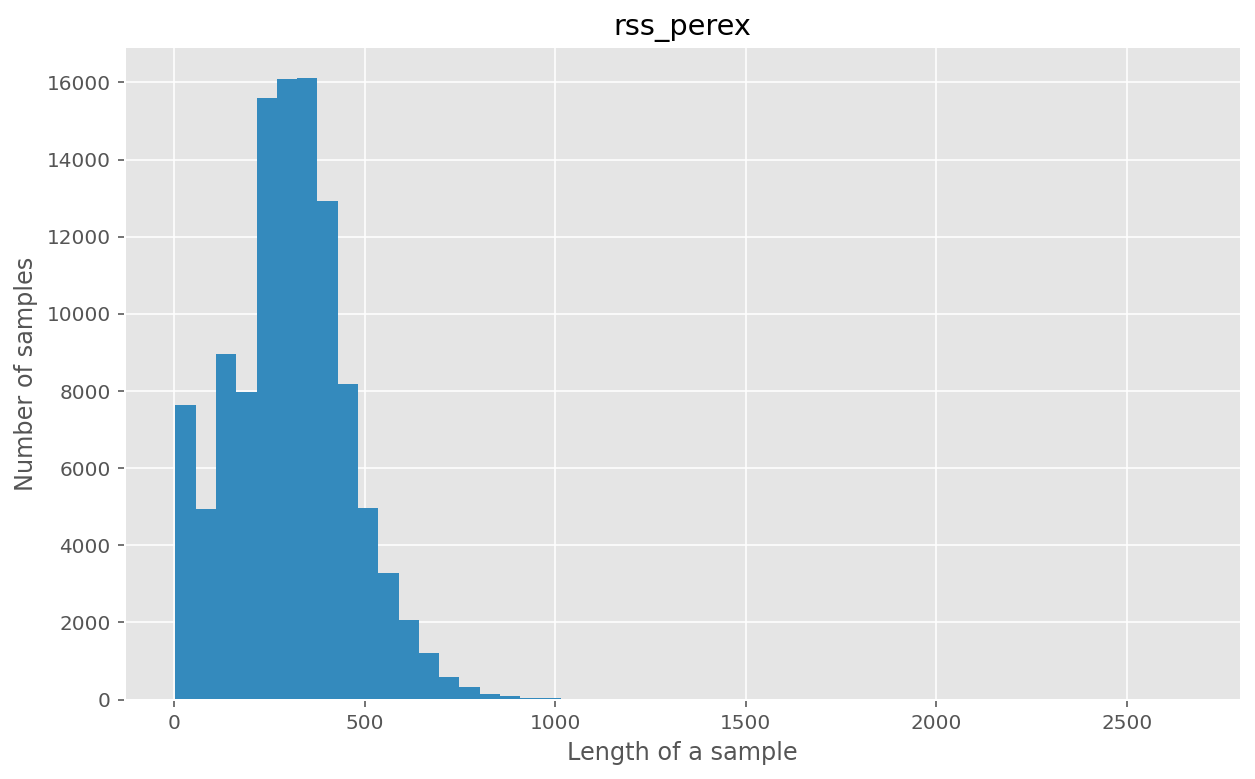

In [8]:
plot_sample_length_distribution(data.rss_title, 'rss_title', c=cmap.colors[0])
plot_sample_length_distribution(data.rss_perex, 'rss_perex', c=cmap.colors[1])

In [9]:
print("perex ratio = {:.0f} [-],\ntitle ratio = {:.0f} [-]".format(
    data.shape[0] / get_num_words_per_sample(data.rss_perex),
    data.shape[0] / get_num_words_per_sample(data.rss_title)))

perex ratio = 2366 [-],
title ratio = 11122 [-]


In [10]:
data_cleaned = data.copy()

for ind, row in tqdm(data.iterrows()):
    # title
    title_ = remove_stop_words(row.rss_title, STOP_WORDS)
    data_cleaned.loc[ind, 'rss_title'] = text_process(title_)
    # perex
    perex_ = remove_stop_words(row.rss_perex, STOP_WORDS)
    data_cleaned.loc[ind, 'rss_perex'] = text_process(perex_)

In [14]:
# ind_bad = data_cleaned.apply(lambda x: len(x.rss_title) <= 2, axis=1)
ind_bad = data_cleaned.apply(lambda x: len(x.rss_perex) <= 2, axis=1)
# ind_bad = data_cleaned.apply(lambda x: len(x.rss_title) == 'test', axis=1)
# ind_bad = (data_cleaned.rss_title == 'test') | (data_cleaned.rss_perex == 'test')
# ind_perex_mutate = ind_bad
# ind_title_mutate = ind_bad

# data_cleaned.drop([42765, 54952], axis=0, inplace=True)
# data_cleaned.loc[110093, 'rss_perex'] = data_cleaned.loc[110093, 'rss_title']

data_cleaned.loc[ind_bad, :]

,category,rss_title,rss_perex
2,biatlon,živě stíhací závod biatlonistek ruhpoldingu,
8,fotbal,živě slavia získala úvod jarní části body jihl...,
2145,biatlon,živě lindström protlačil druhé místo fourcada ...,
3273,biatlon,živě stříbrný šlesingr vyjel mužskému týmu spr...,
8774,biatlon,živě francouzská dvojice potvrdila roli velkéh...,
...,...,...,...
92206,biatlon,živě závod biatlonistů hromadným startem anter...,
93355,tenis,živě strýcová radwaňská češka světovou trojku ...,
94455,biatlon,živě závod biatlonistek hromadným startem ante...,
102297,hokej,živě kometa liberec komu patřit čtvrtý finálov...,


# 2. __Generate syntetic text from BOW__
<a id="feat"></a>

In [15]:
def mutate(text: str, size=None, length=None, replacement=True, logging=False):
    text_d = {i: w for (i, w) in enumerate(text.split())}
    keys = list(text_d.keys())
    keys_mutated = None
    if size is not None:
        keys_mutated = np.random.choice(keys, size=int(size*len(keys)), replace=replacement)
    if length is not None:
        keys_mutated = np.random.choice(keys, size=int(length), replace=replacement)
    if logging:
        logger.info(list(map(len, (keys, keys_mutated))))
    return ' '.join([text_d.get(k) for k in keys_mutated])


def create_bow(ser: pd.Series):
    bow = dict()
    df = pd.DataFrame(ser, columns=[ser.name])
    df.index = np.arange(df.shape[0])
    
    text = ' '.join(ser.values)
    vec = CountVectorizer()
    vec.fit(text.split())
    return ' '.join(vec.get_feature_names())


def generate_text(df, cat='tenis', col='rss_perex', n_examples=1, length=1):
    data_sel = df.loc[df.category == cat, :]
    bow = create_bow(data_sel[col])

    res = list()
    for i in range(n_examples):
        res.append(mutate(bow, length=length))
    return res


def generate_text_cat(cat='tenis'):
    length = data_cleaned.loc[data_cleaned.category == cat, 'rss_perex'].apply(lambda x: len(x.split())).median()
    text_per = generate_text(
        data_cleaned.loc[ind_perex_mutate, :],
        cat=cat,
        col='rss_title',
        n_examples=data_cleaned.loc[(ind_perex_mutate) & (data_cleaned.category == cat), :].shape[0],
        length=length
    )
    return text_per

In [16]:
for cat in data_cleaned.loc[ind_perex_mutate, 'category'].unique():
    data_cleaned.loc[(ind_perex_mutate) & (data_cleaned.category == cat), 'rss_perex'] = generate_text_cat(cat)

data_cleaned.loc[(ind_title_mutate), 'rss_title'] = data_cleaned.loc[(ind_title_mutate), 'rss_perex']
# data_cleaned.loc[(ind_title_mutate), :]

In [14]:
data_cleaned.iloc[np.random.choice(data_cleaned.index, 10, replace=False)]

,category,rss_title,rss_perex
18883,hokej,top zajímavosti nhl nabídek měl nasáno svěřil ...,góly body čísla zámořská nhl přímo topí statis...
34118,cyklistika,štybar rozhodl vynechat slavnou tour france va...,silniční profesionál zdeněk štybar dohodl týme...
44054,hokej,liberec vychoval vrátit tvrdí posila zámoří šmíd,liberce lety odrazil úspěšné kariéře nhl obrán...
107221,fotbal,talent joao teixeira odmítl prodloužit liverpo...,talentovaný portugalský záložník joao teixeira...
77515,moto,brně vyhrál lídr šampionátu can öncü salač out,lídr šampionátu can öncü vyhrál závod red bull...
105143,hokej,kapitán slovanu bratislava žhavým adeptem česk...,slovanu bratislava trénuje český kouč miloš ří...
41521,hokej,hrát jihlavě extraliga karlovy vary nabídly pr...,michal trávníček litvínova vlevo richard diviš...
102227,tenis,berdych porazil mannarina popáté úspěšném obra...,atp los cabos tomáš berdych vyhrál francouzem ...
9634,fotbal,žebříček úspěšnosti týmů historii premier leag...,podívejte žebříček úspěšnosti klubů celou dobu...
10315,florbal,finská radost český zmar,riga čeští florbalisté svou finálovou účast mi...


In [19]:
# check if there are nans
data_cleaned.isna().any()

category     False
rss_title    False
rss_perex    False
dtype: bool

### Check title vs perex correlation

In [29]:
ind = np.random.choice(data_cleaned.index, 10, replace=False)
data_sel = data_cleaned.loc[ind, :]
data_sel['tot'] = data_sel.rss_title + data_sel.rss_perex
data_sel.head(2)

,category,rss_title,rss_perex,tot
50511,fotbal,juventus doma smázl sampdorii nepomohl gól sch...,inter předvedl doma výborný výkon díky dvěma g...,juventus doma smázl sampdorii nepomohl gól sch...
80941,tenis,karolína plíšková obratu vyřadila přemožitelku...,skvělý prožila trávě eastbourne pár dnů začátk...,karolína plíšková obratu vyřadila přemožitelku...


In [30]:
vec = CountVectorizer()
vec.fit((' '.join(data_sel.tot.values)).split())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [31]:
for i, (ind, row) in enumerate(data_sel.iterrows()):
    print(row.rss_title)
    print('-' * 20)
    print(row.rss_perex)
    print(i, '\t'*2, cosine_similarity(
        vec.transform(row.rss_title.split()).sum(axis=0),
        vec.transform(row.rss_perex.split()).sum(axis=0)
    )[0])
    print('*' * 40)

juventus doma smázl sampdorii nepomohl gól schicka icardi zachránil boera džeko pokračuje gólostroji
--------------------
inter předvedl doma výborný výkon díky dvěma gólům maura icardiho porazil turín juventus doma zničil sampdorii poměrem hostům nepomohla branka patricka schicka serii uspěli favorité neapol poradila empoli edin džeko řídil výhru římských vlků ciro immobile dotáhl třem bodům lazio
0 		 [0.27050089]
****************************************
karolína plíšková obratu vyřadila přemožitelku kvitové eastbourne zahraje titul
--------------------
skvělý prožila trávě eastbourne pár dnů začátkem wimbledonu česká tenistka karolína plíšková nejprve dotáhla vítězného konce čtvrtfinálový duel ruskou jelenou vesninovovu pár hodin později vyřadila přemožitelku petry kvitové domácí britku johannu kontaovou vítězství letos zahraje druhé finále
1 		 [0.40147753]
****************************************
sestřih liberec krůček titulu hlinka nedal nájezd sparta padla
--------------------
b

In [34]:
data_cleaned['tot'] = data_cleaned.rss_title + ' ' + data_cleaned.rss_perex

In [35]:
# data_cleaned = pd.read_csv(os.path.join('..', 'data', 'data_cleaned.csv'), index_col=[0])
data_cleaned.head(2)

,category,rss_title,rss_perex,tot
0,biatlon,krčmář dojel hromadném závodě devátý díky skvě...,závod hromadným startem německém oberhofu česk...,krčmář dojel hromadném závodě devátý díky skvě...
1,biatlon,česká vlajka pokljuce vidět štafetách medaile ...,galerie,česká vlajka pokljuce vidět štafetách medaile ...


In [36]:
categories = data_cleaned.category.unique()

In [37]:
# data_cleaned.to_csv(os.path.join('..', 'data', 'data_cleaned.csv'))

In [38]:
# encode categories into ints
cat_encoder = LabelEncoder()
cat_encoder.fit(data_cleaned.category.values)
data_cleaned.category = cat_encoder.transform(data_cleaned.category.values)
data_cleaned.head(2)

,category,rss_title,rss_perex,tot
0,3,krčmář dojel hromadném závodě devátý díky skvě...,závod hromadným startem německém oberhofu česk...,krčmář dojel hromadném závodě devátý díky skvě...
1,3,česká vlajka pokljuce vidět štafetách medaile ...,galerie,česká vlajka pokljuce vidět štafetách medaile ...


In [39]:
gc.collect()

17

# 3. ____Lit review and ways to solve the problem____
<a id="lit"></a>

Very nice state-of-art alogorithms review was found here: ![here](https://lena-voita.github.io/nlp_course/text_classification.html)
and here from Google: ![here](https://developers.google.com/machine-learning/guides/text-classification)

Text processing consists of:

- Tokenization

- Vectorization:
    - Count encoding
    - One-hot encoding
    - Tf-idf encoding
    
- Feature selection opt. (feature importance score for predictions)

- Word embeddings

Currently most succesfully performs transformers (ELMO, Bert), there are models:

- old-classical ones (NB, LogReg, etc.)

- NN (CNN, RNN)

- Transformers (e,beddings trained on large corporus)


# 4. ____Build a baseline____
<a id="base"></a>

In [66]:
SEED = 12345

# test train split
X, y = data_cleaned.drop(['category', 'rss_title', 'rss_perex'], axis=1), data_cleaned.category
X_train, X_test, y_train, y_test = train_test_split(X.tot, y, test_size=0.1, stratify=y, random_state=SEED)
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# train_data.to_csv(os.path.join('..', 'data', 'train_data.csv'))
# test_data.to_csv(os.path.join('..', 'data', 'test_data.csv'))
print(X_train.shape, y_train.shape)
data_cleaned.loc[:2, ['tot']]

(100094,) (100094,)


,tot
0,závod hromadným startem německém oberhofu česk...
1,galerie česká vlajka pokljuce vidět štafetách ...
2,moravě stupně střílela stíhačce dahlmeierová f...


In [67]:
x_train, x_val = ngram_vectorize(
        X_train, y_train, X_test)

x_train.shape, y_train.shape

((100094, 20000), (100094,))

In [68]:
nb = MultinomialNB()
nb.fit(x_train, y_train)

nb_predictions = nb.predict(x_val)
print(classification_report(y_test, nb_predictions))

              precision    recall  f1-score   support

           0       0.88      0.49      0.63       255
           1       0.00      0.00      0.00        14
           2       0.97      0.24      0.39       249
           3       0.99      0.62      0.76       153
           4       0.00      0.00      0.00        15
           5       0.97      0.54      0.69       205
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        53
           8       0.92      0.72      0.81       573
           9       0.74      1.00      0.85      4589
          10       0.00      0.00      0.00         4
          11       1.00      0.36      0.52        45
          12       0.00      0.00      0.00        67
          13       0.93      0.84      0.88      2878
          15       0.00      0.00      0.00         8
          16       1.00      0.33      0.50        96
          17       0.97      0.62      0.76       481
          18       0.87    

# 5) ____Simple LSTM Keras____
<a id="lstm"></a>

# 6) ____LSTM with fasttext embeddings____
<a id="emb"></a>

[Colab](https://colab.research.google.com/drive/18bEoC_w9kz_-fBVy3F4MJNxyIBNVaNtN#scrollTo=6CENenHLcz1T)
lstm.ipynb

In [31]:
with open(emb_f, 'r') as f:
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [32]:
num_words = min(vocabulary, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in tqdm(word_index.items()):
    if i >= vocabulary:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
logging.info('Done building embedding matrix from FastText')        

In [36]:
pd.DataFrame(embedding_matrix).to_csv(os.path.join(data_folder, 'embeddings.csv'))

# 7) ____Dealing with imbalanced data____
<a id="imbalanced"></a>

In [62]:
def generate_text_cat_imb(cat='tenis', n_samples=1):
    length = data_cleaned.loc[data_cleaned.category == cat, 'tot'].apply(lambda x: len(x.split())).median()
    text_per = generate_text(
        data_cleaned,
        cat=cat,
        col='tot',
        n_examples=n_samples,
        length=length
    )
    return text_per


def encode(cat, encoder):
    return encoder.transform([cat])[0]

In [64]:
cats.tail(9)

,category
golf,455
box,149
baseball,143
krasobrusleni,77
rychlobrusleni,65
dostihy,56
rugby,46
futsal,43
hokejbal,6


In [131]:
data_mut = data_cleaned.copy()
ind_last = data_mut.index[-1]
data_mut.head(2)

,category,rss_title,rss_perex,tot
0,3,krčmář dojel hromadném závodě devátý díky skvě...,závod hromadným startem německém oberhofu česk...,krčmář dojel hromadném závodě devátý díky skvě...
1,3,česká vlajka pokljuce vidět štafetách medaile ...,galerie,česká vlajka pokljuce vidět štafetách medaile ...


In [139]:
df_list = list()
# sample_list = [500, 500, 200, 200, 180, 160, 160, 40]
# sample_list = [500, 500, 300, 300, 300, 300, 300, 300]
sample_test = [1_000 for _ in range(8)]

for cat, sample in tqdm(zip(cats.tail(8).index, sample_list)):
    cat_encoded = encode(cat, cat_encoder)
    text = generate_text_cat_imb(
        cat_encoded,
        n_samples=sample - data_cleaned.loc[data_cleaned.category == cat_encoded].shape[0])
    _df = pd.DataFrame(text).rename({0: 'tot'}, axis=1).set_index(np.arange(ind_last, ind_last + len(text)))
    _df['category'] = [encode(cat, cat_encoder) for _ in range(_df.shape[0])]
    df_list.append(_df)
    ind_last = _df.index[-1] + 1

In [140]:
data_mutated = pd.concat([data_mut.loc[:, ['tot', 'category']]] + df_list, axis=0)
print(data_mutated.shape)
print(data_mutated.isna().any())
data_mutated.tail(2)

(113431, 2)
tot         False
category    False
dtype: bool


,tot,category
115645,kolegyně poprvé sobotu výhrou místo výhrou sou...,14
115646,jednoznačnou zahrají trenéra duelu půlnocí sam...,14


In [141]:
# save mutated df
data_mutated.to_csv(os.path.join(data_folder, 'data_mutated.csv'))

# 8) ____LSTM on mutated data____
<a id="lstm_mut"></a>

Colab (lstm.ipynb)

# 9) ____Conclusions and further work____
<a id="cocnlusion"></a>

__What worked or didn't work:__


- overall 

- LST model work just fine: high accuracy, recall, for the task ~ ok.

- Fasttext embeddings didn't improve the results: due to either corpus is a bit different or data was not lemmitized.

- some classes are still needed to be balanced. 


__Next steps:__


1. try to work with text: lemmitize / stem. There is __UDPipe__ service hat works with Czech language as tokenizer/lemmitizer/stemmer via API.

2. try to: 
   - find embeddings / corpus for Czech language; 
   - find datasets with news;
   - find use Seznam API to mine news;


3. tune hyperparameters for LSTM.
   
4. BERT application (slavic BERT or ALBERT) with huge embeddings from wiki. Acc. to arcticles BERT is expected to work __better__.

5. implement ROC AUC for multiclass classification [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)
